# QF 627 Programming and Computational Finance
## Lesson 07 | Unsupervised Learning, PCA, and Portfolio Management |`REVISED`

    Prof. Roh's Note

> Hi Team, as mentioned in the class email, below you'll find pointers for a bug in the functions. Please click on the two sections provided to directly identify the bug and its corresponding solution.

## 👉 <a id = "toc"> <font color = "green"> Revision Pointers</a> 👈 

## [Go and Find Where The Revision is Needed](#revision)

## [A Solution](#solution)

![pca](https://images.squarespace-cdn.com/content/v1/53f3eb3ce4b077de0318f4ea/1628755215426-O3WRR9TNVXU0UFQ2HB68/PCA.gif?format=2500w "pca")

> Hi, Team 👋 Thank you for opening the script 🙂

## DEPENDENCIES

In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import pandas_datareader.data as web
from pandas_datareader import data as pdr

import yfinance as yf

yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(231017)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [2]:
%whos

Variable   Type      Data/Info
------------------------------
dt         module    <module 'datetime' from '<...>onda3\\Lib\\datetime.py'>
mpl        module    <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np         module    <module 'numpy' from 'E:\<...>ges\\numpy\\__init__.py'>
pd         module    <module 'pandas' from 'E:<...>es\\pandas\\__init__.py'>
pdr        module    <module 'pandas_datareade<...>das_datareader\\data.py'>
plt        module    <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
re         module    <module 're' from 'E:\\so<...>3\\Lib\\re\\__init__.py'>
sns        module    <module 'seaborn' from 'E<...>s\\seaborn\\__init__.py'>
time       module    <module 'time' (built-in)>
warnings   module    <module 'warnings' from '<...>onda3\\Lib\\warnings.py'>
web        module    <module 'pandas_datareade<...>das_datareader\\data.py'>
yf         module    <module 'yfinance' from '<...>\\yfinance\\__init__.py'>


## 👉 <a id = "top">Learning Pointers</a> 👈 

## <font color = "green"> Unsupervised Learning for Portfolio Management

    PROBLEM STATEMENT
    
> Our goal is to maximize the risk-adjusted returns of an equity portfolio using PCA on a dataset of stock returns. We will use the Dow Jones Industrial Average (DJIA) index and its respective 30 stocks. The return data is extracted from Yahoo! Finance between January 2000 and January 2019. Ultimately, we will compare the performance of our portfolios against a benchmark and backtest the model to assess the effectiveness of the strategy.

    CONTEXT--In these circumstances, dimensionality reduction is useful.
    
> The primary goal of portfolio management is to allocate capital to different asset classes to maximize risk-adjusted returns. Mean-variance portfolio optimization is the most commonly used technique for asset allocation. This method requires an estimated covariance matrix and expected returns of the assets considered.

> Yet, the fluid nature of financial returns leads to estimation errors in these inputs, especially when the number of samples is much smaller than the number of assets being allocated. These errors pose a threat to the optimization of the resultant portfolios and lead to poor and unstable outcomes.

> We will learn how dimensionality reduction addresses the problem. Using PCA, we can take an n × n covariance matrix of our assets and create a set of n linearly uncorrelated principal portfolios (aka eigen portfolio) made up of our assets and their corresponding variances.

> The principal components of the covariance matrix capture most of the covariation among the assets and are mutually uncorrelated. We can use standardized principal components as the portfolio weights, with the statistical warrants that the returns from these principal portfolios are linearly uncorrelated.

#### Let’s get familiar with a general approach to searching for an eigen portfolio for asset allocation. Starting from understanding concepts of PCA, we will ultimately run backtesting of different principal components.

#### Activate Necessary Packages

> For unsupervised learning

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE

> For EDA and Data Transformation

In [4]:
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix

#### IMPORT Data

In [5]:
dow =\
(
    pd
    .read_csv("https://talktoroh.squarespace.com/s/dow_pca-hemx.csv",
              index_col = 0)
)

In [6]:
dow.head(3)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.52222,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.89986,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.78155,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421


#### Exploratory Data Analysis (EDA)

<Axes: title={'center': 'A Heatmap for Correlation Matrix'}>

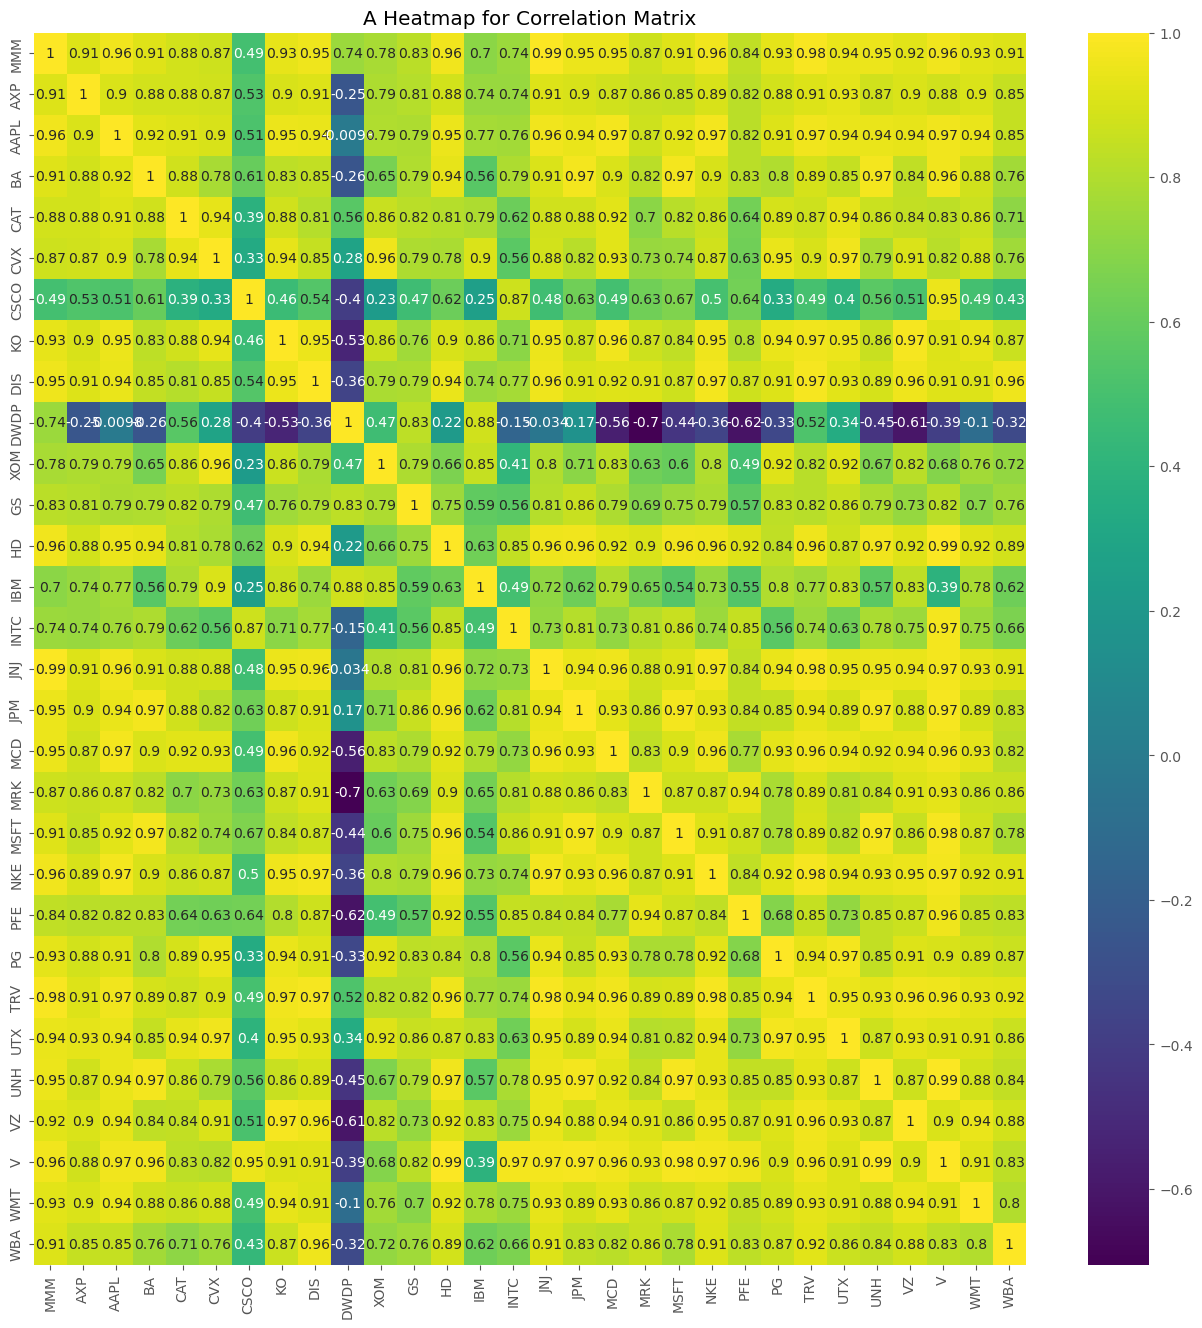

In [7]:
corr = dow.corr()

plt.figure(figsize = [16, 16]
          )

plt.title("A Heatmap for Correlation Matrix")

sns \
    .heatmap(corr,
             annot = True,
             cmap = "viridis")

### Data Transformation

> Stocks were added to the index after the start date (here, January 2000). To ensure proper analysis, we will drop those with more than 30% missing values. Two stocks fit this criteria: Dow Chemicals and Visa.

In [8]:
missing_values =\
(
    dow
    .isnull() # True (1) vs. False (0)
    .mean()
    .sort_values(ascending = False)
)

missing_values.head(10)

DWDP    0.925208
V       0.429792
MMM     0.000000
JPM     0.000000
WMT     0.000000
VZ      0.000000
UNH     0.000000
UTX     0.000000
TRV     0.000000
PG      0.000000
dtype: float64

In [9]:
drop_list =\
(
    sorted(list(missing_values[missing_values > 0.30]
                .index)
          )
)

dow =\
(
    dow
    .drop(labels = drop_list,
          axis = 1)
)

dow.shape[1] == 30 - 2

True

#### Quick question: Please fill the missing values with the last value available in your data.

In [10]:
dow =\
(
    dow
    .fillna(method = "ffill")
)

dow =\
(
    dow
    .dropna(axis = 0)
)

dow.shape

(4800, 28)

#### Calculating Linear Daily Return (`NOT` Log Return)

> Remembert this?
<br>

> `Log returns` (a. k. a. continuously compounded returns) are commonly used in quantitative finance for several reasons:

* `Statistical Properties`: Log returns are approximately normally distributed for many assets, especially when considered over short intervals. This normality simplifies various statistical analyses and hypothesis testing.
<br>

* `Time Additivity`: Log returns are additive across time. For instance, if you have daily log returns, you can easily compute weekly, monthly, or yearly log returns by simply summing the daily log returns over those periods. This is not the case with simple (arithmetic) returns, which need to be compounded.
<br>

* `Small Values for Small Changes`: For assets that don't exhibit large price changes over short time horizons, log returns will remain small, making them easier to work with analytically.
<br>

* `Numerical Stability`: Log returns can provide more numerical stability in certain mathematical and computational operations. For instance, when prices of an asset are multiplied by factors (like in stock splits or dividend payments), log returns remain unaffected, whereas simple returns would change.
<br>

* `Economic Interpretations`: In certain economic and financial theories, continuously compounded returns (log returns) have more straightforward interpretations. For example, the Black-Scholes model for option pricing assumes that stock prices follow a geometric Brownian motion, which inherently deals with log returns.
<br>

* `Symmetry`: Log returns are symmetric. This means that a 10% increase in price followed by a 10% decrease in price will result in a net zero log return, but not a net zero arithmetic return.

### `Asset Additivity vs. Time Additivity`

Both `asset additivity` and `time additivity` are crucial in finance. The choice between log returns and simple returns plays an essential role in these considerations.

### Asset Additivity:

- **Definition**: This concept refers to the ability to compute the combined return of several assets as the weighted sum of their individual returns.
  
- **Simple Returns and Asset Additivity**: 
    - Simple returns are asset-additive. 
    - Given two assets in a portfolio, if \( r_1 \) and \( r_2 \) are the simple returns and \( w_1 \) and \( w_2 \) are their respective weights, then the portfolio return \( R \) is:
        $$ R = w_1 r_1 + w_2 r_2 $$

### Time Additivity:

- **Definition**: This concept refers to the ability to compute the combined return over multiple time periods as the sum (or some other function) of the returns from individual periods.

- **Log Returns and Time Additivity**: 
    - Log returns are time-additive.
    - If \( r_{t1} \) is the log return from time \( t_1 \) to \( t_2 \) and \( r_{t2} \) is the log return from time \( t_2 \) to \( t_3 \), the cumulative log return from \( t_1 \) to \( t_3 \) is: 
        $$ r_{t1} + r_{t2} $$
  
- **Simple Returns and Time Additivity**: 
    - Simple returns are not directly time-additive. 
    - To compute the cumulative simple return over multiple periods, one would multiply the gross returns of each period and subtract one.

### Implications:

- For portfolio returns with multiple assets over a single period, the asset additivity of simple returns is more intuitive.
  
- For returns spanning multiple time periods, the time additivity of log returns makes them more suitable.

> In eigenportfolio analysis, capturing the variance-covariance structure of assets over single periods is often the focus. Hence, the asset additivity of simple returns is more directly relevant. However, for time series analysis or compounded returns over longer frames, log returns could be more appropriate.


In [11]:
Daily_Linear_Return =\
(
    dow
    .pct_change(1)
)

Daily_Linear_Return.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.039733,-0.037838,-0.084331,-0.001493,-0.012955,0.000000,-0.056429,0.003378,0.058568,-0.019155,...,-0.033802,-0.054447,-0.037327,-0.019590,-0.013333,-0.040960,-0.012837,-0.032366,-0.037420,-0.037115
2000-01-05,0.050976,-0.005122,0.014634,0.070022,0.037708,0.021643,0.007843,0.010985,0.035409,0.049733,...,0.010567,0.057802,0.018247,-0.008563,0.009828,-0.009343,-0.002262,0.033448,-0.023325,0.009091
2000-01-06,0.058268,0.000000,-0.086538,0.002795,0.036539,0.038741,-0.027237,-0.001052,-0.034198,0.056555,...,-0.033477,-0.005194,0.033920,0.035509,0.001825,0.036713,0.036645,-0.005088,0.014011,-0.027027
2000-01-07,0.019841,0.013972,0.047368,0.029029,0.032539,0.017577,0.059000,0.065789,-0.015808,-0.002935,...,0.013091,0.000000,0.067781,0.079703,0.039769,0.039636,0.117165,-0.007426,0.075522,0.025556


In [12]:
# Operational defition of outliers = data points beyond 3 SD

Daily_Linear_Return =\
(
    Daily_Linear_Return[Daily_Linear_Return 
                        .apply(lambda x:(x - x.mean()
                                        ).abs() < (3 * x.std()
                                                  )
                              )
                        .all(1)
    ]
)

In [13]:
dow.shape[0] - Daily_Linear_Return.shape[0]

912

#### Important considerations in data transformation for PCA

* All the variables should be on the same scale before applying PCA; otherwise, a feature with large values will dominate the result. Below, we use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).
<br>

* Standardization is a useful technique to transform attributes to a standard Normal distribution with a mean of 0 and a standard deviation of 1.

In [14]:
%whos

Variable              Type         Data/Info
--------------------------------------------
Daily_Linear_Return   DataFrame                     MMM     <...>n[3888 rows x 28 columns]
KernelPCA             type         <class 'sklearn.decomposi<...>n._kernel_pca.KernelPCA'>
PCA                   ABCMeta      <class 'sklearn.decomposition._pca.PCA'>
StandardScaler        type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TSNE                  type         <class 'sklearn.manifold._t_sne.TSNE'>
TruncatedSVD          type         <class 'sklearn.decomposi<...>ncated_svd.TruncatedSVD'>
corr                  DataFrame               MMM       AXP <...>n\n[30 rows x 30 columns]
dow                   DataFrame                       MMM   <...>n[4800 rows x 28 columns]
drop_list             list         n=2
dt                    module       <module 'datetime' from '<...>onda3\\Lib\\datetime.py'>
eig                   function     <function eig at 0x00000255660A1440>
inv         

In [15]:
scaler =\
(
    StandardScaler()
    .fit(Daily_Linear_Return)
)

In [16]:
scaler

StandardScaler()

In [17]:
scaled_dow =\
(
    pd
    .DataFrame(scaler.fit_transform(Daily_Linear_Return),
               columns = Daily_Linear_Return.columns,
               index = Daily_Linear_Return.index)
)

scaled_dow.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
count,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,...,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03,3.888000e+03
mean,-1.096517e-17,4.660195e-17,-1.178755e-16,6.122218e-17,7.401487e-17,-5.117077e-17,3.015421e-17,-1.233581e-17,4.386066e-17,-2.832668e-17,...,5.299830e-17,-9.503144e-17,2.924044e-17,-7.401487e-17,1.827528e-17,2.649915e-17,-1.279269e-16,4.386066e-17,1.827528e-18,4.020561e-17
std,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,...,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00
min,-3.922680e+00,-4.354756e+00,-3.724824e+00,-3.699053e+00,-3.687384e+00,-3.796937e+00,-4.357221e+00,-4.011341e+00,-4.052353e+00,-3.824479e+00,...,-4.229289e+00,-3.937974e+00,-3.898983e+00,-4.094951e+00,-4.300197e+00,-3.812740e+00,-3.963000e+00,-3.992325e+00,-3.998857e+00,-3.805467e+00
25%,-5.508673e-01,-4.932035e-01,-5.308158e-01,-5.972063e-01,-5.672663e-01,-5.926707e-01,-4.945972e-01,-5.585051e-01,-5.457730e-01,-5.930095e-01,...,-5.593274e-01,-5.735131e-01,-5.636374e-01,-5.578035e-01,-5.454868e-01,-5.681795e-01,-5.628937e-01,-5.844426e-01,-5.612429e-01,-5.998348e-01
50%,1.004186e-03,-8.222333e-03,-2.275294e-02,-1.030006e-02,-1.653397e-02,1.706494e-02,2.517189e-03,1.007874e-02,1.815486e-03,-1.302072e-02,...,-2.607098e-02,-1.459050e-02,-2.509767e-02,-1.441778e-02,-5.004709e-04,-1.002697e-02,-1.724701e-02,1.182292e-02,-4.940312e-04,-1.994830e-02
75%,5.881598e-01,5.270321e-01,5.396618e-01,6.073168e-01,5.789699e-01,6.066429e-01,5.414868e-01,5.576045e-01,5.583852e-01,5.958424e-01,...,5.521367e-01,5.538539e-01,5.645856e-01,5.445446e-01,5.458177e-01,5.621201e-01,5.617994e-01,5.782902e-01,5.567668e-01,5.885685e-01
max,3.947963e+00,4.322067e+00,3.923732e+00,3.805431e+00,3.806188e+00,3.716547e+00,4.317517e+00,4.043916e+00,4.041645e+00,3.725121e+00,...,4.128677e+00,4.055188e+00,3.868939e+00,4.171749e+00,4.315234e+00,3.981293e+00,4.001403e+00,3.751665e+00,4.100298e+00,3.754610e+00


In [18]:
scaled_dow.dtypes

MMM     float64
AXP     float64
AAPL    float64
BA      float64
CAT     float64
CVX     float64
CSCO    float64
KO      float64
DIS     float64
XOM     float64
GS      float64
HD      float64
IBM     float64
INTC    float64
JNJ     float64
JPM     float64
MCD     float64
MRK     float64
MSFT    float64
NKE     float64
PFE     float64
PG      float64
TRV     float64
UTX     float64
UNH     float64
VZ      float64
WMT     float64
WBA     float64
dtype: object

<Axes: title={'center': 'AAPL Return'}, xlabel='Date', ylabel='Linear Return'>

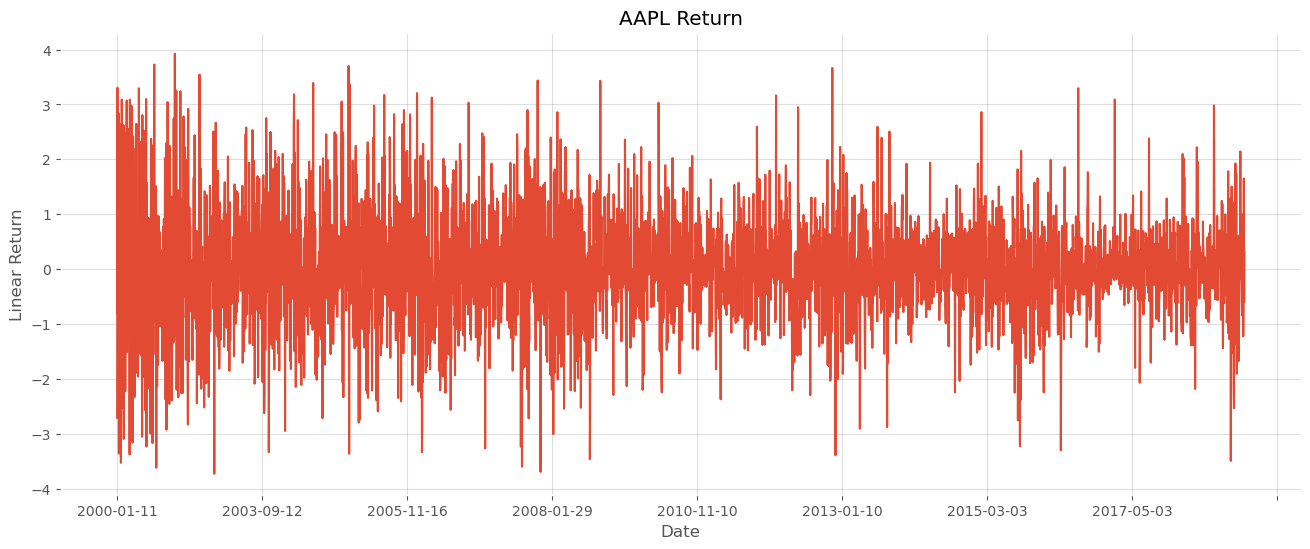

In [19]:
plt.figure(figsize = [16, 6]
          )

plt.title("AAPL Return")

plt.ylabel("Linear Return")

(
    scaled_dow
    ["AAPL"]
    .plot()
)

### MODEL

#### Data Split

> Let’s divide the portfolio into training and testing data split to execute the analysis regarding the best portfolio and backtesting down the line.

In [20]:
prop =\
    int(len(scaled_dow) * 0.80)

X_Train = scaled_dow[    : prop] # First 80% of the data
X_Test  = scaled_dow[prop:     ] # Remaining 20% of the data

X_Train_Raw = Daily_Linear_Return[    :prop]
X_Test_Raw  = Daily_Linear_Return[prop:    ]

In [21]:
stock_tickers =\
(
 scaled_dow
 .columns
 .values
)

stock_tickers

array(['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS',
       'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK',
       'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT',
       'WBA'], dtype=object)

### Apply Principal Component Analysis

> Let’s run a function to compute principal component analysis using the sklearn module. We run create a function that computes an inversed elbow chart showing the number of principle components and how many of them explain the variance threshold.

### Fitting: Model Comparison with ML Algorithms

In [22]:
%whos

Variable              Type              Data/Info
-------------------------------------------------
Daily_Linear_Return   DataFrame                          MMM     <...>n[3888 rows x 28 columns]
KernelPCA             type              <class 'sklearn.decomposi<...>n._kernel_pca.KernelPCA'>
PCA                   ABCMeta           <class 'sklearn.decomposition._pca.PCA'>
StandardScaler        type              <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TSNE                  type              <class 'sklearn.manifold._t_sne.TSNE'>
TruncatedSVD          type              <class 'sklearn.decomposi<...>ncated_svd.TruncatedSVD'>
X_Test                DataFrame                          MMM     <...>\n[778 rows x 28 columns]
X_Test_Raw            DataFrame                          MMM     <...>\n[778 rows x 28 columns]
X_Train               DataFrame                          MMM     <...>n[3110 rows x 28 columns]
X_Train_Raw           DataFrame                          MMM     <..

In [23]:
pca = PCA()

PrincipalComponent = pca.fit(X_Train)

In [24]:
PrincipalComponent

PCA()

#### First Principal Component /Eigenvector

In [25]:
dir(pca)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_features_out',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'feature_na

In [26]:
pca.components_[0]

array([-0.228, -0.228, -0.153, -0.19 , -0.202, -0.178, -0.195, -0.168,
       -0.208, -0.193, -0.209, -0.202, -0.199, -0.195, -0.167, -0.228,
       -0.152, -0.17 , -0.194, -0.171, -0.19 , -0.168, -0.198, -0.227,
       -0.138, -0.167, -0.169, -0.161])

> `pca.components_` is a matrix where each row is a principal component, and the columns correspond to the original features of the data. The components are sorted by their explained variance, with the first component explaining the most variance.

> `pca.components_[0]` retrieves the first row of the matrix, which is the first principal component. It is an eigenvector that points in the direction of the highest variance in the data after accounting for the variance captured by earlier components.

### Explained Variance

> Let’s look at the variance explained using PCA. The decline in the variance of the original data explained by each principal component reflects the correlation among the original features. 

> The eigenvectors with the lowest eigenvalues describe the least amount of variation within the dataset. These values can be dropped. Let's display the number of principal components and the variance explained by each.

In [27]:
NumEigenValues = 10

<Axes: title={'center': 'Cumulative Explained Variance by Each PC'}>

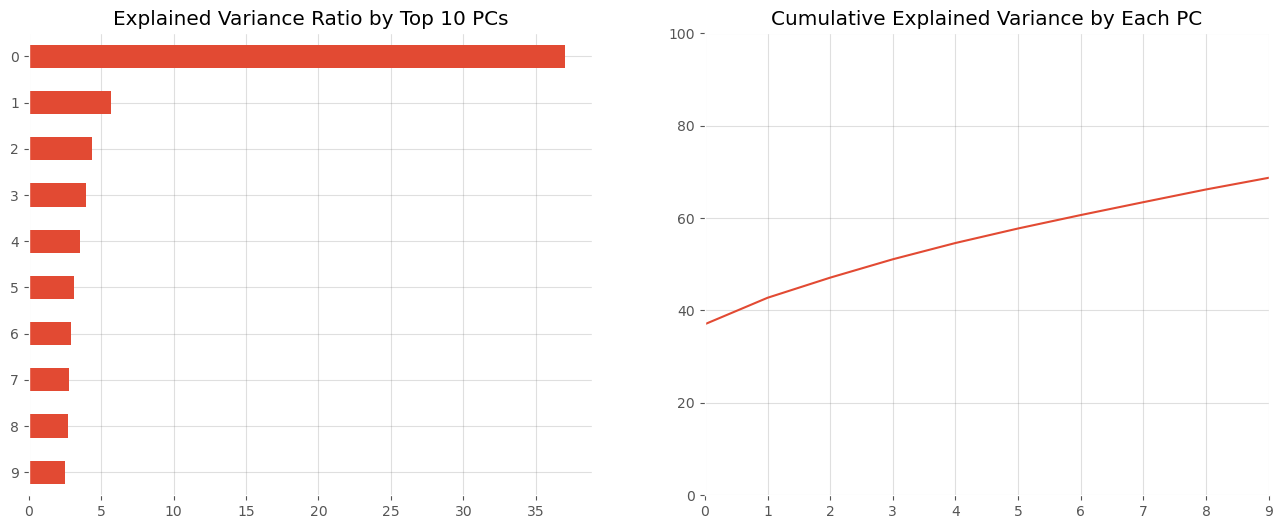

In [28]:
fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

# Plot on the left panel

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)

# Plot on the right panel

Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 9),
          title = "Explained Variance Ratio by Top 10 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 9),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)

> The first principal component captures the most variance in the original data; the second component represents the second highest variance; and so on.

In [29]:
(
    pd
    .Series(np
           .cumsum(pca
                   .explained_variance_ratio_)
           )
    .to_frame("Explained Variance")
    .head(NumEigenValues)
    .style
    .format("{:,.2%}".format)
)

,Explained Variance
0,37.04%
1,42.75%
2,47.11%
3,51.08%
4,54.61%
5,57.75%
6,60.65%
7,63.44%
8,66.19%
9,68.71%


### Portfolio Weights

> Let’s take a close look at individual principal components. The features may be less interpretable than the original features now. Yet, we can look at the weights of the factors on each principal component to examine any intuitive themes relative to the 28 stocks.

In [30]:
# pca.components_

In [31]:
def PCWeights():

    weights = pd.DataFrame()

    for i in range(len(pca.components_)
                  ):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i]
                                                                  )

    weights = weights.values.T
    return weights # Team, be careful with indentation

#### A Step-by-Step Guidance

> A new empty DataFrame, weights, is initialized.

> The function loops through each principal component (eigenvector) in pca.components_.

> For each component, it calculates the normalized weights by dividing each component by the sum of its values. This ensures that the weights for each component sum up to 1.

> These normalized weights are added as a new column to the weights DataFrame.

> After processing all components, the DataFrame is transposed (`.values.T`) to have components as rows and the original features as columns.

* The resulting matrix will have each principal component's normalized weights, sorted by the order of explained variance (i.e., the first row corresponds to the first principal component, the second row to the second component, and so on).

In [32]:
weights = PCWeights()

In [33]:
weights[0]

array([0.043, 0.044, 0.029, 0.036, 0.038, 0.034, 0.037, 0.032, 0.04 ,
       0.037, 0.04 , 0.039, 0.038, 0.037, 0.032, 0.043, 0.029, 0.032,
       0.037, 0.033, 0.036, 0.032, 0.038, 0.043, 0.026, 0.032, 0.032,
       0.031])

> Let’s construct five portfolios, defining the weights of each stock as each of the first five principal components. Then, let’s create a scatterplot that visualizes an organized descending plot with the respective weight of every company at the current chosen principal component.

In [34]:
# Set the number of principal components to be considered
NumComponents = 5

# Extract the top principal components from the PCA object
# and create a DataFrame with columns named after the original features

topPortfolios =\
(
    pd
    .DataFrame(pca.components_[ : NumComponents],
               columns = dow.columns)
)

# Normalize the weights of the top portfolios such that the weights sum up to 1 for each portfolio
# This is done by dividing each weight by the sum of weights for the respective portfolio

eigen_portfolios =\
(
    topPortfolios
    .div(topPortfolios.sum(1),
         axis = 0)
)

# Rename the index of the eigen_portfolios DataFrame for better readability

eigen_portfolios.index = [f"Portfolio {i}" for i in range(NumComponents)
                         ]

# Calculate the square root of the explained variance for each component
# This provides the standard deviation of returns for each eigenportfolio

np.sqrt(pca.explained_variance_)

array([3.319, 1.304, 1.138, 1.087, 1.023, 0.967, 0.93 , 0.911, 0.904,
       0.866, 0.854, 0.843, 0.816, 0.793, 0.777, 0.775, 0.758, 0.754,
       0.733, 0.726, 0.706, 0.682, 0.674, 0.656, 0.648, 0.607, 0.567,
       0.448])

In [35]:
# eigen_portfolios

In [36]:
eigen_portfolios.iloc[0]

MMM     0.043399
AXP     0.043523
AAPL    0.029155
BA      0.036177
CAT     0.038487
CVX     0.033941
CSCO    0.037154
KO      0.032085
DIS     0.039660
XOM     0.036810
GS      0.039793
HD      0.038581
IBM     0.037977
INTC    0.037205
JNJ     0.031800
JPM     0.043456
MCD     0.028888
MRK     0.032408
MSFT    0.036928
NKE     0.032630
PFE     0.036196
PG      0.032003
TRV     0.037657
UTX     0.043170
UNH     0.026311
VZ      0.031815
WMT     0.032181
WBA     0.030611
Name: Portfolio 0, dtype: float64

array([[<Axes: title={'center': 'Portfolio 0'}>],
       [<Axes: title={'center': 'Portfolio 1'}>],
       [<Axes: title={'center': 'Portfolio 2'}>],
       [<Axes: title={'center': 'Portfolio 3'}>],
       [<Axes: title={'center': 'Portfolio 4'}>]], dtype=object)

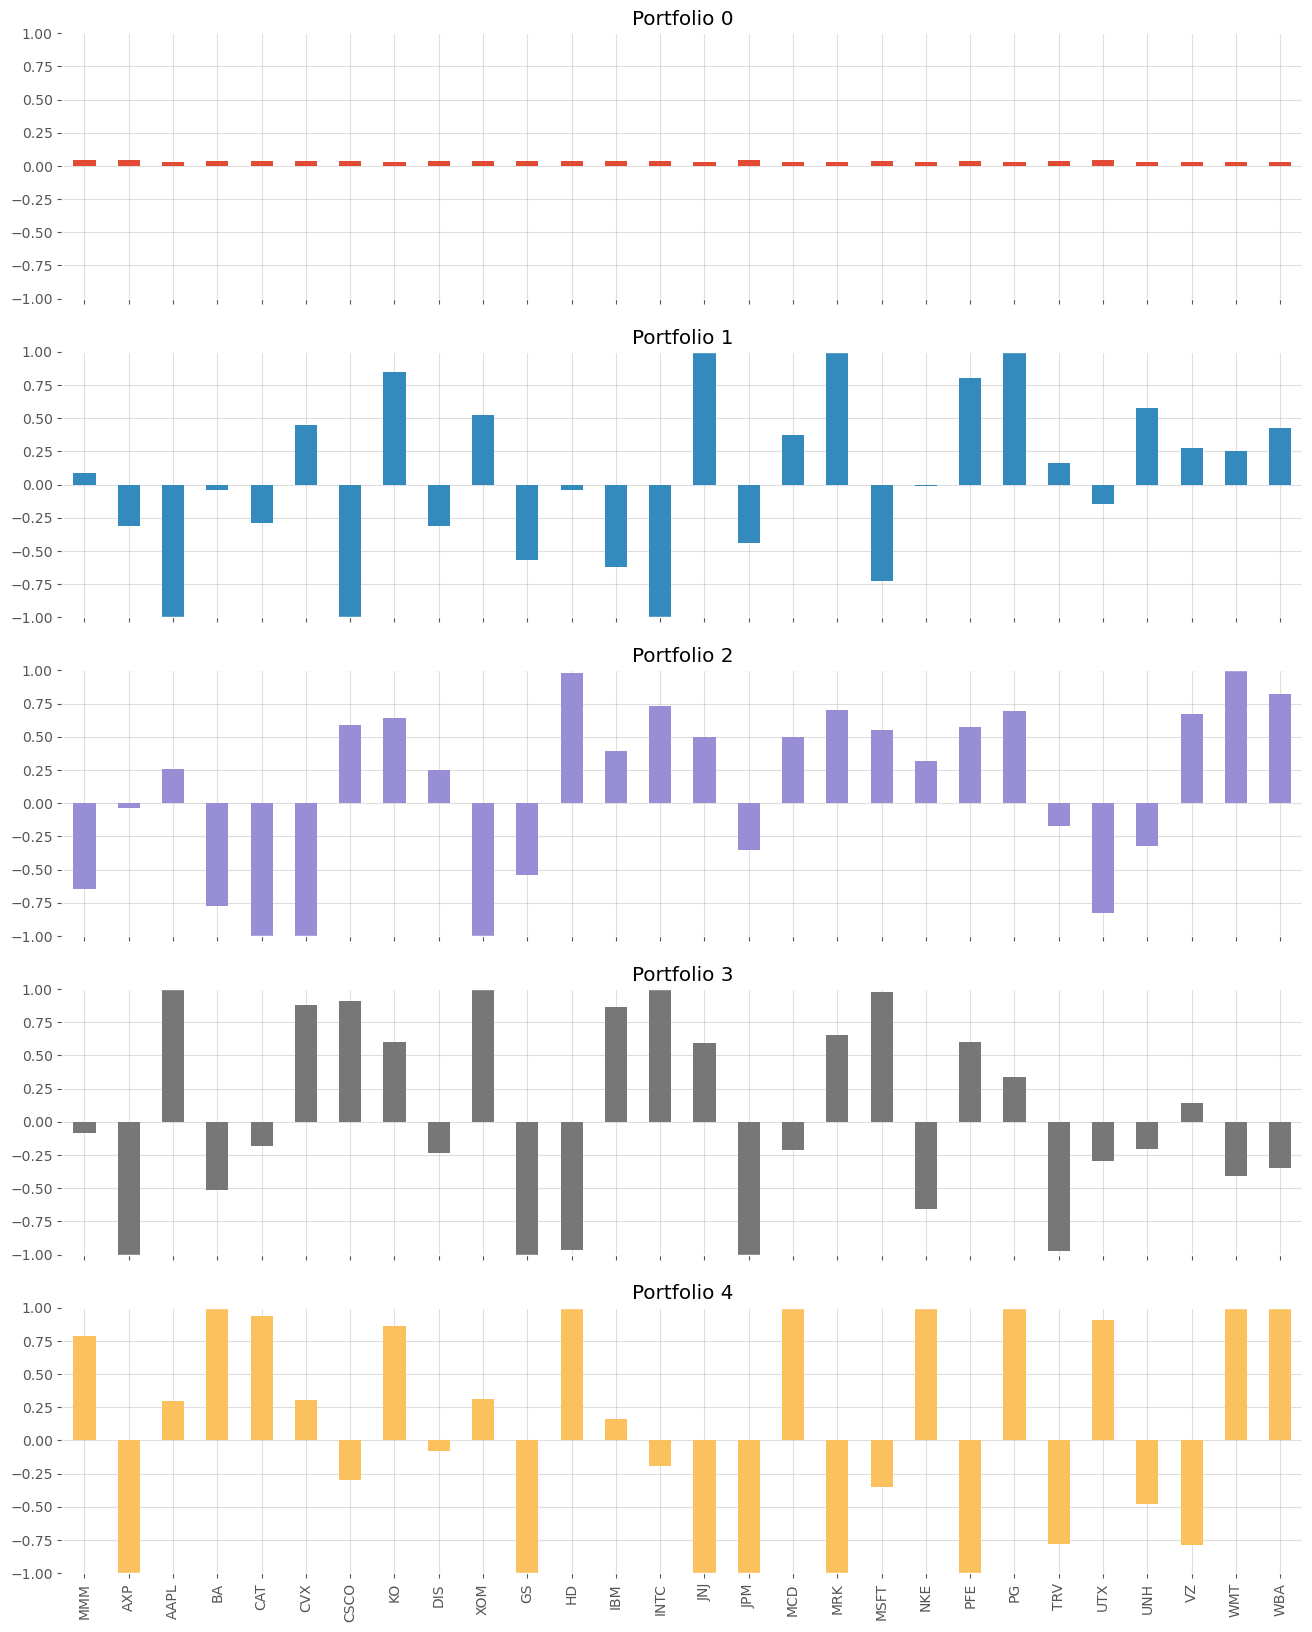

In [37]:
(
    eigen_portfolios
    .T  # Transpose the DataFrame to have portfolios as columns and assets as rows
    .plot
    .bar(subplots = True,
         layout = (int(NumComponents), 1),
         legend = False,
         sharey = True,
         figsize = [16, 20],
         ylim = [-1, 1]
        )
)

> The heatmap and the plot above shown the contribution of different stocks in each eigenvector.

<Axes: >

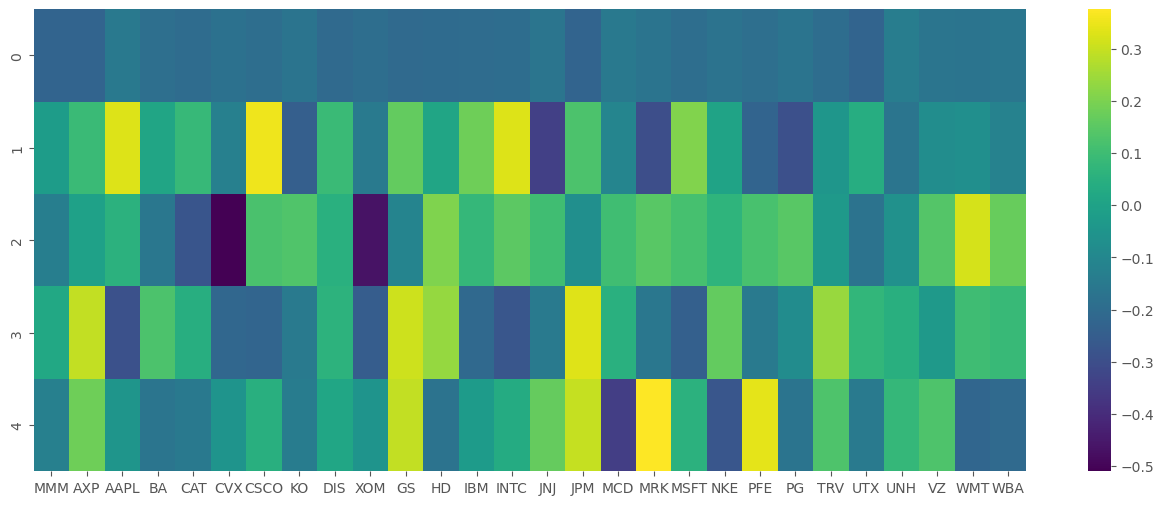

In [38]:
plt.figure(figsize = [16, 6]
          )

sns.heatmap(topPortfolios,
            cmap = "viridis")

### Equal-weigthed Portfolio vs. PCA-based Portfolio

> An equal-weighted portfolio is a portfolio in which all assets are given the same weight, regardless of their individual risk and return characteristics. This means that each asset contributes equally to the overall portfolio, regardless of its performance.

> In contrast, a PCA-based portfolio (an eigen portfolio) is a portfolio that is constructed using a mathematical technique called principal component analysis (PCA). PCA is a statistical technique used to identify the underlying factors that explain the co-movement of asset returns. The eigen portfolio is a portfolio that is constructed using the eigenvectors of the covariance matrix of the asset returns.

> An eigen portfolio may be better than an equal-weighted portfolio for several reasons:

- `Improved Diversification`: The eigen portfolio is designed to capture the most important sources of risk in the market. By investing in these sources of risk, the eigen portfolio may provide improved diversification compared to an equal-weighted portfolio, which may be more exposed to idiosyncratic risk.
<br>

- `Improved Risk-Adjusted Returns`: The eigen portfolio is designed to capture the factors that explain the most variance in the market. By investing in these factors, the eigen portfolio may provide improved risk-adjusted returns compared to an equal-weighted portfolio, which may be more exposed to less important factors.
<br>

- `More Efficient`: The eigen portfolio is constructed using a mathematical technique that is designed to be more efficient than an equal-weighted portfolio. This means that the eigen portfolio may provide better risk-adjusted returns for a given level of risk.
<br>

Taken together, an eigen portfolio may provide better risk-adjusted returns and improved diversification compared to an equal-weighted portfolio. However, it's important to note that the performance of any portfolio will depend on the specific assets included and the market conditions.

### How to Find the Best Eigen Portfolio

> To determine the best eigen portfolio, let’s employee the Sharpe ratio. As you have learned, the Sharpe ratio is an assessment of risk-adjusted performance that explains the annualized returns against the annualized volatility of a portfolio.

In [39]:
def calculate_sharpe_ratio(ts_returns, periods_per_year = 252):

    n_years = ts_returns.shape[0] / periods_per_year

    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                ) - 1

    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)

    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

> Let's construct a loop to compute the principle component’s weights for each eigen portfolio, which then uses the sharpe ratio function to look for the portfolio with the highest sharpe ratio. 

In [40]:
# %whos

In [41]:
# Gift

def recommend_optimal_portfolio():

    # Number of eigenportfolios or principal components
    
    n_portfolios = len(pca.components_)

    # Initialize arrays for annualized return, volatility, and Sharpe ratio of each eigenportfolio
    
    annualized_ret = np.array([0.] * n_portfolios)

    sharpe_metric = np.array([0.] * n_portfolios)

    annualized_vol = np.array([0.] * n_portfolios)

    # Variable to track the index of the eigenportfolio with the highest Sharpe ratio
    
    highest_sharpe = 0

    # Extract stock tickers from the scaled data
    
    stock_tickers =\
    (scaled_dow
     .columns 
     .values)

    n_tickers = len(stock_tickers)

    # Extract principal components
    
    PCs = pca.components_

    # Loop through each eigenportfolio

    for i in range(n_portfolios):

        # Normalize the weights of the i-th eigenportfolio
        
        pc_w = PCs[i] / sum(PCs[i])

        # Create a DataFrame for the eigenportfolio weights
        
        eigen_prtfi =\
            (
                pd
                .DataFrame(data = {"weights": pc_w.squeeze() * 100},
                           index = stock_tickers)
            )

        # Calculate returns for the eigenportfolio
        
        eigen_prti_returns =\
            (
                np
                .dot(X_Train_Raw,
                     pc_w)
            )

        eigen_prti_returns =\
            (
                pd
                .Series(eigen_prti_returns.squeeze(),
                        index = X_Train_Raw.index)
            )

        # Calculate annualized return, volatility, and Sharpe ratio for the eigenportfolio
        
        er, vol, sharpe = calculate_sharpe_ratio(eigen_prti_returns)

        # Store the metrics in their respective arrays
        
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

        # Replace NaN values in Sharpe metric array with zeros
        
        sharpe_metric = np.nan_to_num(sharpe_metric)

    # Let's find a portfolio with the HIGHEST Sharpe Ratio

    highest_sharpe = np.argmax(sharpe_metric)

    # Print the details of the eigenportfolio with the highest Sharpe ratio
    
    print("Our Eigen Portfolio #%d with the highest Sharpe\
           \nReturn %.2f%%,\vol = %.2f%%, \nSharpe = %.2f" %
         (highest_sharpe,
          annualized_ret[highest_sharpe] * 100,
          annualized_vol[highest_sharpe] * 100,
          sharpe_metric[highest_sharpe]
         )
         )

    # Create a DataFrame to store the results for all eigenportfolios
    
    results =\
        (
            pd
            .DataFrame(data = {"Return": annualized_ret,
                               "Vol": annualized_vol,
                               "Sharpe": sharpe_metric}
                      )
        )

    results.dropna(inplace = True)

    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)

    # Print the top 10 eigenportfolios based on Sharpe ratio

    print(results.head(10)
         )

In [42]:
recommend_optimal_portfolio()

Our Eigen Portfolio #0 with the highest Sharpe           
Return 11.60%,ol = 13.44%, 
Sharpe = 0.86
      Return        Vol    Sharpe
0   0.115981   0.134411  0.862886
10  0.494180   0.924699  0.534422
5   0.297760   1.136205  0.262065
18 -1.000000  19.450857 -0.051412
7  -0.061040   0.796040 -0.076679
4  -0.198197   1.307909 -0.151537
23 -0.999980   4.388914 -0.227842
21 -0.246107   1.023621 -0.240427
3  -0.255145   1.040654 -0.245178
25 -0.999868   3.990359 -0.250571


> Once we figure out which portfolio has the highest sharpe ratio, we can visualize its performance against the DJIA Index for comparison.

### Make it even better: Add Visual Display of Eigen-Portfolios

In [43]:
def FindPortfolioVisual():
    
    n_portfolios = len(pca.components_)
    
    annualized_ret = np.array([0.] * n_portfolios)
    
    sharpe_metric = np.array([0.] * n_portfolios)
    
    annualized_vol = np.array([0.] * n_portfolios)
    
    highest_sharpe = 0
    
    stock_tickers = scaled_dow.columns.values
    
    n_tickers = len(stock_tickers)
    
    PCs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = PCs[i] / sum(PCs[i]
                           )
        
        eigen_prtfi = pd.DataFrame(data = {"weights": pc_w.squeeze()*100}, 
                                   index = stock_tickers)
        
        eigen_prti_returns =\
        (
            np
            .dot(X_Train_Raw, 
                 pc_w)
        )
        
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(),
                                       index = X_Train_Raw.index)
        
        er, vol, sharpe = calculate_sharpe_ratio(eigen_prti_returns)
        
        annualized_ret[i] = er
        
        annualized_vol[i] = vol
        
        sharpe_metric[i] = sharpe
        
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    # HOW TO FIND A PORTFOLIO with the HIGHEST Sharpe Ratio
    
    highest_sharpe = np.argmax(sharpe_metric)
    
    print("Our Eigen Portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f" %
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100,
           annualized_vol[highest_sharpe]*100,
           sharpe_metric[highest_sharpe]
          )
         )
        
    #####
    
    fig, ax = plt.subplots()
    
    fig.set_size_inches(16, 6)
    
    ax.plot(sharpe_metric, 
            linewidth = 2)
    
    ax.set_title("Sharpe Ratio of Eigen-Portfolios")
    
    ax.set_ylabel("Sharpe Ratio")
    
    ax.set_xlabel("Portfolios")
    
    #####
        
    results = pd.DataFrame(data = {"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric}
                           )
    
    results.dropna(inplace = True)
    
    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)
    
    print(results.head(15)
         )
    
    plt.show()

> As shown from the results above, the portfolio `OO` is the best portfolio and has the maximum sharp ratio out of all the porfolio. Let us look at the composition of this portfolio. 

Our Eigen Portfolio #0 with the highest Sharpe. Return 11.60%, vol = 13.44%, Sharpe = 0.86
      Return        Vol    Sharpe
0   0.115981   0.134411  0.862886
10  0.494180   0.924699  0.534422
5   0.297760   1.136205  0.262065
18 -1.000000  19.450857 -0.051412
7  -0.061040   0.796040 -0.076679
4  -0.198197   1.307909 -0.151537
23 -0.999980   4.388914 -0.227842
21 -0.246107   1.023621 -0.240427
3  -0.255145   1.040654 -0.245178
25 -0.999868   3.990359 -0.250571
6  -0.541024   1.920136 -0.281763
8  -0.494671   1.693916 -0.292028
19 -0.998979   3.236577 -0.308653
27 -0.373132   1.177402 -0.316912
26 -0.991823   3.020807 -0.328331


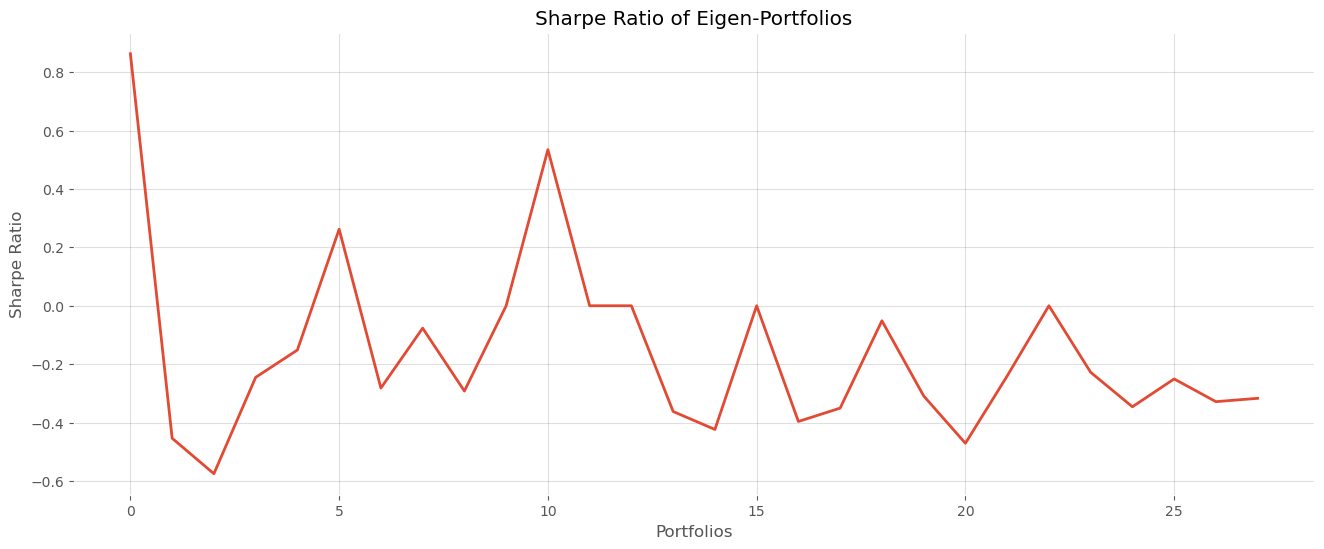

In [44]:
FindPortfolioVisual()

> The figure shows the allocation of the best portfolio. The weights in the chart are in percentages.

### Backtesting Our `Eigen` Portfolio

> Let’s backtest our algorithm on the test set. We will look at a few of the top performers and the worst performer.
 
> The outperformance or underperformance here is attributed to the weights of the stocks or sectors in the eigen portfolio. We can examine these further to identify the individual drivers of each portfolio.

# <a id = "revision"> </a> <font color = "red"> Where Revision is Needed </font> [back to table of contents](#toc)

    Prof. Roh's Note

> Let's pinpoint the location of the bug. I've added a sanity check below to clearly highlight the issue.

> As demonstrated below, the ValueError message reveals a mismatch: the order of tickers in eigen_prtfi (sorted based on their weights) does not align with the column order in X_Test_Raw. This misalignment creates complications when computing the dot product in the original function.

In [45]:
# Yet another gift

def backtest_PCA_porfolios(eigen):

    eigen_prtfi =\
        (
            pd
            .DataFrame(data = {"weights": eigen.squeeze()
                              },
                       index = stock_tickers)
        )

    eigen_prtfi.sort_values(by = ["weights"],
                            ascending = False,
                            inplace = True)

    # Let's run a Sanity Check: Order of tickers in eigen_prtfi and X_Test_Raw should match
    if not list(eigen_prtfi.index) == list(X_Test_Raw.columns):
        
        raise ValueError(f"Prof. Roh's Message: 'Sanity check failed T.T' Order of tickers in eigen_prtfi and X_Test_Raw don't match.\n\
                           Eigen_prtfi order:{list(eigen_prtfi.index)}\nX_Test_Raw order: {list(X_Test_Raw.columns)}")
    
    eigen_prtfi_returns = np.dot(X_Test_Raw.loc[:, eigen_prtfi.index], eigen)
    
    eigen_prtfi_returns =\
    (
        np
        .dot(X_Test_Raw
             .loc[ : , eigen_prtfi.index],
             eigen)
    )

    eigen_portfolio_returns =\
    (
        pd
        .Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)
    )

    returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)

    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"  %
          (returns * 100, vol * 100, sharpe)
         )

    # Compared with what? Equal-weightage Portfolio

    equal_weight_return =\
    (
        X_Test_Raw * (1 / len(pca.components_)
                     )
    ).sum(axis = 1)

    df_plot =\
        (
            pd
            .DataFrame({"ML Portfolio Return": eigen_portfolio_returns,
                        "Equal Weight Index": equal_weight_return},
                      index = X_Test.index
                      )
        )

    (
        np
        .cumprod(df_plot + 1)
        .plot(title = "Returns of the equal weighted index vs. Eigen-Portfolio",
              figsize = [16, 8]
             )
    )

    plt.show()

In [46]:
backtest_PCA_porfolios(eigen = weights[5]
                      )

ValueError: Prof. Roh's Message: 'Sanity check failed T.T' Order of tickers in eigen_prtfi and X_Test_Raw don't match.
                           Eigen_prtfi order:['UNH', 'WBA', 'AAPL', 'PFE', 'UTX', 'NKE', 'BA', 'JNJ', 'HD', 'MMM', 'MRK', 'CSCO', 'CAT', 'INTC', 'MSFT', 'IBM', 'WMT', 'GS', 'DIS', 'CVX', 'JPM', 'AXP', 'TRV', 'XOM', 'MCD', 'PG', 'KO', 'VZ']
X_Test_Raw order: ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'WBA']

# <a id = "solution"> </a> <font color = "green"> Where there is a bug, there is a SOLUTION </font> [back to table of contents](#toc)

    Prof. Roh's Note

> As indicated by the above ValueError, the core issue arises because the columns of `X_Test_Raw` are reordered based on `the sorted order of tickers` from `eigen_prtfi` for the dot product. However, `the unsorted weights` from `eigen` are used, `leading to the discrepancy`.
        
> To rectify the original function, we need to eliminate the sorting. Simply perform the dot product of X_Test_Raw with eigen without any sorting. This approach will yield the correct portfolio returns, provided the order of tickers in X_Test_Raw corresponds to the order in eigen. Let's use function `valid_backtest_PCA_porfolios()`.

> Additionally, the functions `recommend_optimal_portfolio()` and `FindPortfolioVisual()` have been updated in line with these changes.

In [ ]:
def valid_backtest_PCA_porfolios(eigen):
    
    eigen_prtfi =\
        (
            pd
            .DataFrame(data = {"weights": eigen.squeeze()
                              },
                       index = stock_tickers)
        )

    # Sanity Check: Ensure the order of tickers in X_Test_Raw matches the order in eigen
    if not list(eigen_prtfi.index) == list(X_Test_Raw.columns): 
        raise ValueError("Sanity check failed: Mismatch in number of tickers between X_Test_Raw and eigen.")
    else:
        print("Prof. Roh's Message: 'Sanity check succeeded :)' The order of tickers in X_Test_Raw matches the order in eigen.")
    
    # Let's directly compute the dot product without sorting
    eigen_prtfi_returns =\
    (
        np
        .dot(X_Test_Raw, eigen)
    )
    
    eigen_portfolio_returns =\
    (
        pd
        .Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)
    )

    returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)

    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"  %
          (returns * 100, vol * 100, sharpe)
         )

    # Compared with what? Equal-weightage Portfolio

    equal_weight_return =\
    (
        X_Test_Raw * (1 / len(pca.components_)
                     )
    ).sum(axis = 1)

    df_plot =\
        (
            pd
            .DataFrame({"ML Portfolio Return": eigen_portfolio_returns,
                        "Equal Weight Index": equal_weight_return},
                      index = X_Test.index
                      )
        )

    (
        np
        .cumprod(df_plot + 1)
        .plot(title = "Returns of the equal weighted index vs. Eigen-Portfolio",
              figsize = [16, 8]
             )
    )

    plt.show()

In [ ]:
valid_backtest_PCA_porfolios(eigen = weights[5]
                             )

    NOTE
    
> Given that these eigen portfolios are independent, they also provide diversification opportunities. As such, we can invest across these uncorrelated eigen portfolios, providing other potential portfolio management benefits.

### What We Learned from Unsupervised Learning

> Before this session, we learned supervised learning techniques to build machine learning models using data where the answer was already known (i.e., the class labels were available in our input data). 

> In the current session, we learned unsupervised learning, where we draw inferences from datasets consisting of input data when the answer is unknown.

> Unsupervised learning algorithms attempt to infer patterns from the data without any knowledge of the output the data is meant to produce. Without requiring labeled data, which can be time-consuming and impractical to create or acquire, unsupervised learning allows for easy use of larger datasets for analysis and model development.

> As an unsupervised learning method, dimensionality reduction compresses the data by finding a smaller, different set of variables that capture what matters most in the original features, while minimizing the loss of information. 

> Dimensionality reduction helps mitigate problems associated with high dimensionality and permits the visualization of salient aspects of higher-dimensional data that is otherwise difficult to explore.

> In practice, our datasets are often large and with many dimensions. Dimensionality reduction will be practical and useful as it allows us to reduce noise and redundancy in the data, having data with fewer features.

> `Thank you for working with the script, Team 👍`